# Neural Nets from scratch, in Numpy

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from autograd import grad, elementwise_grad, jacobian, numpy as autograd_np

## Network Architecture

LeCun et. al.'s seminal LeNet-5 is a great basic network to grok the implementation of the math behind neural nets. To begin with, we define a set of activation functions that add non-linearity to what is otherwise essentially a complex linear regression solver:

### Activations

In [67]:
def _relu(x):
    return autograd_np.maximum(0, x)

def _sigmoid(x):
    x_clip = autograd_np.clip(x, -700, 700)
    return 1 / (1 + autograd_np.exp(-x_clip))

def _softmax(x):
    # Subtract max for numerical stability (avoids overflow from exp)
    shifted_x = x - autograd_np.max(x)
    exps = autograd_np.exp(shifted_x)
    return exps / autograd_np.sum(exps)

activation_function_map = {
    'relu': _relu,
    'sigmoid': _sigmoid,
    'softmax': _softmax
}

Next, we define loss functions to measure the quality of the output layer. Since this is a classification problem, we need class membership probabilities; the sigmoid function is used as the activation of the final layer for this. The loss function, therefore, must compare this class membership probability vector against the label (ground truth) for that training observation. 

### Loss Functions

In [74]:
def _rmse(y, y_pred):
    # RMSE = sqrt of (1/n) summation{ (y_i - y_pred_i)**2 }
    return autograd_np.sqrt((1/y.shape[0]) * np.sum((y - y_pred) ** 2))

def _crossentropy(y, y_pred):
    # Prevent log(0)
    eps = 1e-15
    y_pred = autograd_np.clip(y_pred, eps, 1 - eps)

    # CE = -summation{ (y_i * log(y_pred_i) + (1-y_i)*log(1-y_pred_i)}
    return (1/y.shape[0]) * -autograd_np.sum((y * autograd_np.log(y_pred)) + ((1-y) * autograd_np.log(1-y_pred)))

def _softmax_crossentropy(y_true, y_pred):
    eps = 1e-15
    y_pred = autograd_np.clip(y_pred, eps, 1 - eps)
    return -autograd_np.sum(y_true * autograd_np.log(y_pred))


## The Dense Layers 

The LeNet-5 architecture implements three dense (fully-connected) layers after feature extraction. This class defines a layer and supports weight and bias management - both during initialization as well as during backpropagation

In [111]:
class FullyConnectedLayer():
    def __init__(self, layer_config):
        self.input_size = layer_config['input_dim']
        self.output_size = layer_config['output_dim']
        self.id = layer_config.get('id', None)

        # For random normal, mu=0, sigma=1
        mu, sigma = 0, 1
        self.W = np.random.normal(loc=mu, scale=sigma, size=(self.output_size, self.input_size))
        self.b =  np.random.normal(loc=mu, scale=sigma, size=self.output_size)
        activation_function = 'relu' if not layer_config.get('activation') else layer_config.get('activation')
        self.activation = activation_function_map[activation_function]
        
        # Current Layer: pre-activation and output values
        self.z = None
        self.a = None

        # Previous Layer: pre-activation output values for backprop
        self.prev_layer_z = None
        self.prev_layer_a = None


    def forward(self, input):
        """
        Implement the forward pass.

        Args:
            input: A previous FC Layer or the raw input x values. This will be used to compute z and a, and keeps track of prev_z and prev_a
                for use during backpropagation.
        Returns:
            None
        """
        if isinstance(input, FullyConnectedLayer):
            x = input.a # input is the previous FC layer, not raw values, so extract the post-activation vector a
            self.prev_layer_z = input.z
            self.prev_layer_a = input.a   
        else:
            x = input # input is the raw X values
            self.prev_layer_z = None
            self.prev_layer_a = input

        # Ensure we do not anger the numpy gods
        assert x.shape[0] == self.W.shape[1], f"Shape mismatch: input dim {x.shape[0]} but W expects {self.W.shape[1]}"

        # Computation 1: z[l] = W[l]·x + b[l] (x = a[l-1] if the input is a FC layer, otherwise x=x) 
        self.z = np.dot(self.W, x) + self.b
        # Computation 2: a[l] = activation(z[l])
        self.a = self.activation(self.z)

    def backward(self, dA):
        """
        Implement backpropagation.
        
        Args:
            dA: Gradient of loss L wrt. the output (activation) of this layer. Shorthand for to dL/da
        Returns:
            dA[l-1]: Gradient of loss L wrt. the output of the previous layer, for backprop.
        """

        # Step 1: Compute error signal dL/dz[l] called del[l] = dL/da[l] x σ'(z[l]), where σ' = activation derivative
        # del[l] = dL/da[l] x σ'(z[l]) 
        activation_derivative = elementwise_grad(self.activation) # σ'()
        self.del_l = dA * activation_derivative(self.z) # dL/da[l] x σ'(z[l]) 

        # override
        if self.activation.__name__ == '_softmax':
            self.del_l = dA  # because dL/dz = a - y

        # Step 2: Compute loss grad wrt. W and b of current layer i.e. dL/dW[l] and dL/db[l]
        # dL/dw i.e. dW = del[l] x a[l-1].T
        # dL/db i.e. db = del[l]
        self.dW = np.outer(self.del_l, self.prev_layer_a)
        self.db = self.del_l

        # Step 3: Propagate dL/da[l-1] backwards to use in the del[l] calculation (Step 1) in the previous layer
        # del[l-1]  = W[l].T * del[l] * σ'(z[l-1])

        if self.prev_layer_z is not None:
            del_l_prev = np.dot(self.W.T, self.del_l) * activation_derivative(self.prev_layer_z)
        else:
            del_l_prev = np.dot(self.W.T, self.del_l)
        
        return del_l_prev
    
    def step(self, learning_rate):
        self.W = self.W - learning_rate * self.dW
        self.b = self.b - learning_rate * self.db


## Gathering Data: MNIST

LeNet-5 was trained on actual handwritten digits extracted from material belonging to the US Postal Service; fortunately, as the dataset is foundation ald quite popular, it is available to download and parse easily:

In [5]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

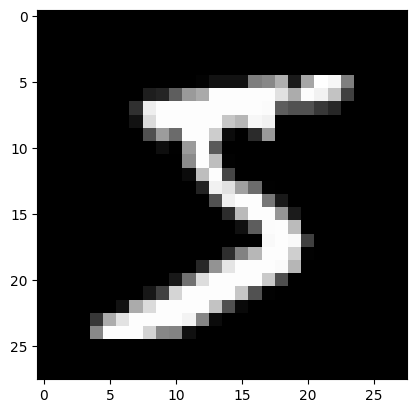

In [6]:
plt.imshow(X.values[0].reshape(28,28), cmap='gray')

## Implementing LeNet-5 (under construction)

### 1. The first forward pass

In [7]:
# LeNet-5 (only dense layers for testing)
input_layer =  FullyConnectedLayer(layer_config={'input_dim': 784,'output_dim': 30, 'activation': 'relu', 'id': 'input'})
hidden_layer = FullyConnectedLayer(layer_config={'input_dim': 30, 'output_dim': 10, 'activation': 'relu', 'id': 'hidden'})
output_layer = FullyConnectedLayer(layer_config={'input_dim': 10, 'output_dim': 10, 'activation': 'sigmoid', 'id': 'output'})

# Pick a sample from the training data and dump it directly into the first dense layer (input_layer).
# NOTE: for learning purposes only - eventually, there will be additional layers behind the dense layers 
# and so the output of those layers will be funneled into the first dense layer instead.
sample_num = 42
x = X.values[sample_num].copy()

# Forward pass through all layers
input_layer.forward(input=x)
hidden_layer.forward(input_layer)
output_layer.forward(hidden_layer)

# Compare prediction vs ground truth
y_true = np.eye(10)[int(y.values[sample_num])] 
y_pred = output_layer.a
loss = _crossentropy(y_true, y_pred)

print(f"Actual class label for sample {sample_num}: \n{y_true}")
print(f"Predicted class label probabilities for sample {sample_num} (rounded): \n{np.round(y_pred, decimals=3)}")
print(f"\nCrossEntropy Loss for first forward pass: {loss}")

Actual class label for sample 42: 
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Predicted class label probabilities for sample 42 (rounded): 
[0. 1. 1. 1. 1. 0. 0. 1. 0. 0.]

CrossEntropy Loss for first forward pass: 13.815830396936352


### Okay, now what?
We now have a loss value that compares the actual class label (which will only have a single 1 in the one-hot-encoded vector of size $n$, where $n$ is the number of classes). The next step is, naturally, to adjust weights and biases so the error is not so high next time - but how? We need some way to understand:

1. How the loss $L$ changes given a change in the network output $a^{[l]}$: $\frac{dL}{da^{[l]}}$
2. How a change in the weights $W$ or biases $b$ affects this $a^{[l]}$ value, and therefore the loss $L$: $\frac{dL}{dW}$ and $\frac{dL}{db}$. 

How do we do this? **Calculus!** 

As we enumerated above in point #2, we now need to evaluate the two terms $\frac{dL}{dW}$ and $\frac{dL}{db}$ and use the chain rule to see how $\frac{dL}{da^{[l]}}$ is affected.

1. 
    $\frac{dL}{dW} 
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dW} 
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}} \times \frac{dz^{[2]}}{dW}$ 

    $Since \ \frac{dz^{[2]}}{dW} =  \frac{d(W^{[2]}a^{[1]} + b^{[2]})}{dW} = a^{[1]}$,

    $Therefore \ \frac{dL}{dW} = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}} \times a^{[1]}$

2. 
    $\frac{dL}{db}
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{db} 
    = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}} \times \frac{dz^{[2]}}{db}$ 

    $Since \ \frac{dz^{[2]}}{db} =  \frac{d(W^{[2]}a^{[1]} + b^{[2]})}{db} = 1$,

    $Therefore \ \frac{dL}{db} = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}}$

<br />

The term $\frac{dL}{da^{[l]}} \times \frac{da^{[2]}}{dz^{[l]}}$ simplifies to $\frac{dL}{dz^{[l]}}$ and is called the *error signal* $\delta^{[l]}.$ Using this info, we can rewrite both expressions as:

$\frac{dL}{dW} = \delta^{[2]} \times a^{[1]}$, and 
$\frac{dL}{db} = \delta^{[2]}$.

### 2. The Loss Gradient and Backpropagation

In [8]:
# Compute gradient of loss wrt model output, i.e. dL/da[2]
loss_grad = grad(_crossentropy)
gradients = loss_grad(y_true, y_pred)
print(f"grad: {gradients}")

grad: [ 3.45387764 -3.4539576  -3.4539576  -3.4539576  -3.4539576   3.45387764
  3.45387764 -3.4539576   3.45387764  3.45387764]


Okay great! Now that we know the math, and have computed $\frac{dL}{da^{[l]}}$ in the cell above, it's time to implement it as code. We'll start with the error signal $\delta^{[l]}$.

#### The error signal $\delta^{[l]}$
Now, to compute these terms in the backward() method of a layer $l$, we first compute the value of the $\delta^{[l]}$ vector (in this network, backprop starts from $l=2$):
 
$\delta^{[2]} = \frac{dL}{da^{[2]}} \times \frac{da^{[2]}}{dz^{[2]}} = gradients \times \sigma'(z^{[2]})$, where $\sigma$ is the activation function in layer $2$ and $\sigma'$ is its derivative.

As code, ```del_l = dA * activation_derivative(self.z)```

Next, we use this $\delta^{[2]}$ term in the calculations for $\frac{dL}{dW} \ and \ \frac{dL}{db}:$

$\frac{dL}{dW} = \delta^{[2]} \times a^{[1]}, \ \frac{dL}{db} = \delta^{[2]}$.

As code:
```dW = np.outer(del_l, self.prev_layer_a)```, ```db = np.outer(del_l, self.prev_layer_a)```

<br />

#### Backpropagating the error signal

When we started the backprop process, we looked at how the loss $L$ changes given a change in the network output $a^{[l]}$. i.e.: $\frac{dL}{da^{[l]}}$.

This framework holds true for the previous layer as well. From its perspective, it is *also* recieving a loss signal, but unlike the final layer, it is not the *"gradient of loss wrt network output"* but rather the *"gradient of loss wrt **previous layer output"***: $\frac{dL}{da^{[l-1]}}$.

This is the core of backprop: at each layer $l$, we compute $\frac{dL}{da^{[l-1]}}$ and propagate it back to the previous layer $l-1$ to be used in the $\delta^{[l-1]}$ calculation of that $l-1$ layer. Using the chain rule,

$\frac{dL}{da^{[1]}} = \frac{dL}{dz^{[2]}} \times \frac{dz^{[2]}}{da^{[1]}}$. We already know $\frac{dL}{dz^{[2]}} = \delta^{[2]}$, so

$\frac{dL}{da^{[1]}} = \delta^{[2]} \times \frac{dz^{[2]}}{da^{[1]}} = \delta^{[2]} \times \frac{d(W^{[2]}a^{[1]})}{da^{[1]}}$. Taking the derivative of that final term,

$\frac{dL}{da^{[1]}} = \delta^{[2]} \times W^{[2]}.$ 

This is straightforward to implement in the backward() method of layer $l$:

```np.dot(self.W.T, del_l) * activation_derivative(self.prev_layer_z)```

In [9]:
# Backpropagate!
dA = gradients
dA_2 = output_layer.backward(dA)
dA_1 = hidden_layer.backward(dA_2)
dA_0 = input_layer.backward(dA_1)

/Users/avenugopal/Desktop/Prep/Python/jupyter-notebooks/.venv/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),


### 3. A step in the right(?) direction

Now that the gradients $\frac{dL}{dW}$ and $\frac{dL}{db}$ have been computed across all layers, it is finally time to fine-tune the weights and biases accordingly. Our math above tells us that the weight vector $W$ and the bias vector $b$ eventually influence the loss L, so nudging them slighly according to the computed gradients *should* reduce the loss.

I say *should*, because there can be local minima in the loss surface that the gradients naturally pick up on.

#### Adjusting weights $W^{[l]}$ and biases $b^{[l]}$
Now that we have $\frac{dL}{dW}$ and $\frac{dL}{db}$ for layer $l$, we can adjust the weights $W^{[l]}$ and biases $b^{[l]}$ for layer $l$. 

These gradients wrt. to the loss represents the direction of steepest increase in the loss surface - essentially, it represents the direction to maximally *increase* loss. We want the opposite of this (maximally *decrease* loss), so  we perform the 'nudge', or *step* in the *opposite* direction of the gradient by using a $-$ sign:

$$W = W - \frac{dL}{dW}$$

$$b = b - \frac{dL}{db}$$

However, since the error terms are quite high in magnitude especially at the start of training, directly stepping in a direction will produce a huge change in the parameters. To control this, we introduce a learning rate $\eta$, which is used as a reduction/control factor in the step:

$$W = W - \eta \frac{dL}{dW}$$

$$b = b - \eta \frac{dL}{db}$$

In deep learning math convention, all trainable params (so the weights and biases) are represented by $\theta$. The optimizing step can therefore be written in a single expression as:

$$\theta \leftarrow \theta - \eta \Delta_{\theta}L$$


As code, 

```self.W = self.W - learning_rate * self.dW```

```self.b = self.b - learning_rate * self.b```

<br />

In [10]:
learning_rate = 0.01
output_layer.step(learning_rate=learning_rate)
hidden_layer.step(learning_rate=learning_rate)
input_layer.step(learning_rate=learning_rate)


## Trying out a smaller dataset before MNIST

||dW|| (output): 488.8002425107878
||dW|| (output): 540.4382604032429
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214134
||dW|| (output): 655.9871335214133
||dW|| (output): 655.9871335214133
||dW|| (output): 655.9871335214133
||dW|| (output): 655.9871335214133
||dW|| (output): 655.9871335214133
||dW|| (output): 655.9871335214133
||dW|| (output): 655.9871335214133
||dW|| (output): 655

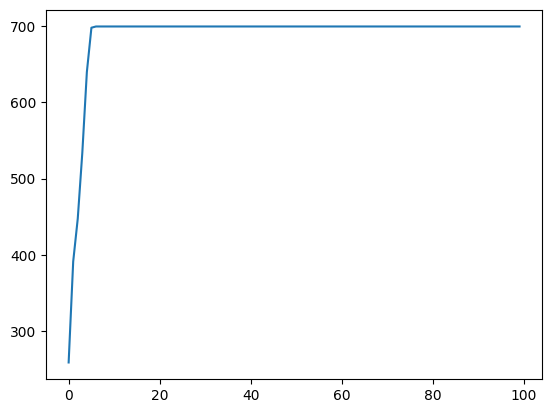

In [119]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# One-hot encode target
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Train-test split (optional, keep 80% train for now)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Network setup
input_layer = FullyConnectedLayer({'input_dim': 4, 'output_dim': 8, 'activation': 'relu'})
hidden_layer = FullyConnectedLayer({'input_dim': 8, 'output_dim': 5, 'activation': 'relu'})
output_layer = FullyConnectedLayer({'input_dim': 5, 'output_dim': 3, 'activation': 'softmax'})

# Training loop
learning_rate = 0.00005
num_epochs = 100
loss_curve = []

for epoch in range(num_epochs):
    epoch_loss = 0

    for i in range(X_train.shape[0]):
        x = X_train[i]  
        y_true = y_train[i]

        # Forward pass
        input_layer.forward(x)
        hidden_layer.forward(input_layer)
        output_layer.forward(hidden_layer)

        y_pred = output_layer.a
        loss = _softmax_crossentropy(y_true, y_pred)
        epoch_loss += loss

        #print(y_true)
        #print(np.round(y_pred, decimals=3))
        #print()

        # Backpropagation
        loss_grad = grad(_softmax_crossentropy)
        dA = loss_grad(y_true, y_pred)
        #print("dA:", dA)

        dA_2 = output_layer.backward(dA)
        dA_1 = hidden_layer.backward(dA_2)
        dA_0 = input_layer.backward(dA_1)

        # Update weights
        output_layer.step(learning_rate)
        hidden_layer.step(learning_rate)
        input_layer.step(learning_rate)

    print(f"||dW|| (output): {np.linalg.norm(output_layer.dW)}")
    avg_loss = epoch_loss / X_train.shape[1]
    #print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    loss_curve.append(avg_loss)

plt.plot(range(num_epochs),loss_curve)